## 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード $t$ に対するジニ不純度 $I(t)$ は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。
$$I(t)=1-\sum_{i=1}^K P^2(C_i|t)=1-\sum_{i=1}^K(\frac{N_{t,i}}{N_{t, all}})^2$$

In [1]:
def get_gini(count_array):
    
    """
    gini不純度を計算する関数
    
    param
    --------------------
    count_array : 次の形のndarray(クラス数, )
    各クラスに属しているサンプルの数
    
    return
    ---------
    gini : float
    ジニ不純度
    """
    # 合計値の算出
    n_sample = count_array.sum()
    
    sum_array = np.array([])
    
    for i in count_array:
        sum_array = np.append(sum_array, (i / n_sample) ** 2)
    gini = 1 - sum_array.sum()
    
    return gini

# 【問題2】情報利得を求める関数
次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 $I(t)$ を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。


ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。
$$IG(p) = I(p) - \frac{N_{left,all}}{N_{p, all}}I(left) - \frac{N_{right,all}}{N_{p, all}}I(right)$$

In [2]:
def get_information_gain(P_array, left_array, right_array):
    """
    情報利得を計算する関数
    
    param
    -------------------
    P_array : 次の形のndarray(クラス数, )
    各クラスに属している親ノードサンプルの数
    left_array : 次の形のndarray(クラス数, )
    各クラスに属している左ノードサンプルの数
    right_array : 次の形のndarray(クラス数, )
    各クラスに属している右ノードサンプルの数
    
    return
    -------------------
    情報利得 : float
    """
    
    IG = get_gini(P_array) - ((left.sum() / P_array.sum()) * get_gini(left_array)) - ((right.sum() / P_array.sum()) * get_gini(right_array))
    return IG

# 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。


訓練データに対してすべての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。


クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。


《組み合わせの取り方》


すべての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。


他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。


《補足》


問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$ は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

In [3]:
def fit(X, y):
    
    #
    # 前処理
    #
    
    # yを(n_sample, 1)の形に変更
    y = y.reshape(y.shape[0], 1)
    
    # Xと列方向に結合
    Xy = np.concatenate([X, y], axis=1)
    
    # Xy(親ノード)のクラス分類を取得
    Xy_unique, Xy_count = np.unique(Xy[:, 2], return_counts=True)
    
    # flag用の行列を作成,結合
    Xy_flag = np.zeros((Xy.shape[0], 1))
    Xy = np.concatenate([Xy, Xy_flag], axis=1)
    
    # 初期値
    max_IG = -1
    X_max = -1
    
    for k in range(Xy.shape[1]-2):
        # 特徴量１番目において全ての値で実装
        for j in range (len(Xy)):
            #
            # それぞれ分類後のサンプルを格納するためのndarrayを作成 + ラベル付
            #
            left_count = 0
            right_count = 0
            for i in range (len(Xy)):
                if Xy[i, k] > Xy[j, k]:
                    Xy[i, 3] = 0
                    left_count += 1
                else:
                    # 右に分類されているサンプルの４列目に1を格納
                    Xy[i, 3] = 1
                    right_count += 1

            # 分類後のサンプル数を格納できるような形を作る
            left = np.zeros((left_count, Xy.shape[1]))
            right = np.zeros((right_count, Xy.shape[1]))

            #
            # ラベルごとに実際に格納
            #

            # 格納の順番のために必要、再初期化
            left_count = 0
            right_count = 0

            for i in range (len(Xy)):
                if Xy[i, 3] == 0:
                    # leftの上から順番に書き換えていく
                    left[left_count] = Xy[i]
                    left_count += 1

                else:
                    # rightの上から順番に書き換えていく
                    right[right_count] = Xy[i]
                    right_count += 1

            # 個数が欲しいので分ける
            left_unique, left_count = np.unique(left[:, 2], return_counts=True)
            right_unique, right_count = np.unique(right[:, 2], return_counts=True)

            # 最大利得の時のクラス分けに使用した値と情報利得を取得
            IG = get_information_gain(Xy_count, left_count, right_count)
        

            if max_IG < IG:
                max_IG = IG
                max_j, max_k = j, k
                
    #
    # 情報利得が一番大きくなる場合
    #
    
    left_count = 0
    right_count = 0
    for i in range (len(Xy)):
        if Xy[i, max_k] > Xy[max_j, max_k]:
            Xy[i, 3] = 0
            left_count += 1
        else:
            # 右に分類されているサンプルの４列目に1を格納
            Xy[i, 3] = 1
            right_count += 1

    # 分類後のサンプル数を格納できるような形を作る
    left = np.zeros((left_count, Xy.shape[1]))
    right = np.zeros((right_count, Xy.shape[1]))

    # 格納の順番のために必要、再初期化
    left_count = 0
    right_count = 0

    for i in range (len(Xy)):
        if Xy[i, 3] == 0:
            # leftの上から順番に書き換えていく
            left[left_count] = Xy[i]
            left_count += 1

        else:
            # rightの上から順番に書き換えていく
            right[right_count] = Xy[i]
            right_count += 1

    # 個数が欲しいので分ける
    left_unique, left_count = np.unique(left[:, 2], return_counts=True)
    right_unique, right_count = np.unique(right[:, 2], return_counts=True)    
    
    # 3個目のの列を削除        
    left = np.delete(left, 3, 1)
    right = np.delete(right, 3, 1)
    
    IG = get_information_gain(Xy_count, left_count, right_count)
    
    return left_count, right_count

# 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。


入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

# 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [4]:
import numpy as np
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装
    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
    
    def get_gini(self, count_array):
    
        """
        gini不純度を計算する関数

        param
        --------------------
        count_array : 次の形のndarray(クラス数, )
        各クラスに属しているサンプルの数

        return
        ---------
        gini : float
        ジニ不純度
        """
        # 合計値の算出
        n_sample = count_array.sum()

        sum_array = np.array([])

        for i in count_array:
            sum_array = np.append(sum_array, (i / n_sample) ** 2)
        gini = 1 - sum_array.sum()

        return gini
    
    
    def get_information_gain(self, P_array, left_array, right_array):
        """
        情報利得を計算する関数

        param
        -------------------
        P_array : 次の形のndarray(クラス数, )
        各クラスに属している親ノードサンプルの数
        left_array : 次の形のndarray(クラス数, )
        各クラスに属している左ノードサンプルの数
        right_array : 次の形のndarray(クラス数, )
        各クラスに属している右ノードサンプルの数

        return
        -------------------
        情報利得 : float
        """

        IG = self.get_gini(P_array) - ((left_array.sum() / P_array.sum()) * self.get_gini(left_array)) - ((right_array.sum() / P_array.sum()) * self.get_gini(right_array))
        return IG
        
        
    def fit(self, X, y):
        
        """
        情報利得が最大になる特徴量の値を取得する
        
        param
        ------------------
        X : 次の形のndarray(n_sample, n_feature)
        訓練データの特徴量
        y : 次の形のndarray(n_sample, 1)
        訓練データの正解ラベル
        """

        #
        # 前処理
        #

        # yを(n_sample, 1)の形に変更
        y = y.reshape(y.shape[0], 1)

        # Xと列方向に結合
        Xy = np.concatenate([X, y], axis=1)

        # Xy(親ノード)のクラス分類を取得
        Xy_unique, Xy_count = np.unique(Xy[:, 2], return_counts=True)

        # flag用の行列を作成,結合
        Xy_flag = np.zeros((Xy.shape[0], 1))
        Xy = np.concatenate([Xy, Xy_flag], axis=1)

        # 初期値
        max_IG = -1
        X_max = -1

        for col in range(Xy.shape[1]-2):
            # 特徴量１番目において全ての値で実装
            for index in range (len(Xy)):
                #
                # それぞれ分類後のサンプルを格納するためのndarrayを作成 + ラベル付
                #
                left_count = 0
                right_count = 0
                for i in range (len(Xy)):
                    if Xy[i, col] <= Xy[index, col]:
                        Xy[i, 3] = 0
                        left_count += 1
                    else:
                        # 右に分類されているサンプルの４列目に1を格納
                        Xy[i, 3] = 1
                        right_count += 1

                # 分類後のサンプル数を格納できるような形を作る
                left = np.zeros((left_count, Xy.shape[1]))
                right = np.zeros((right_count, Xy.shape[1]))

                #
                # ラベルごとに実際に格納
                #

                # 格納の順番のために必要、再初期化
                left_count = 0
                right_count = 0

                for i in range (len(Xy)):
                    if Xy[i, 3] == 0:
                        # leftの上から順番に書き換えていく
                        left[left_count] = Xy[i]
                        left_count += 1

                    else:
                        # rightの上から順番に書き換えていく
                        right[right_count] = Xy[i]
                        right_count += 1

                # 個数が欲しいので分ける
                left_unique, left_count = np.unique(left[:, 2], return_counts=True)
                right_unique, right_count = np.unique(right[:, 2], return_counts=True)

                # 最大利得の時のクラス分けに使用した値と情報利得を取得
                IG = self.get_information_gain(Xy_count, left_count, right_count)

                # 最大値を取得
                if max_IG < IG:
                    max_IG = IG
                    self.max_IG_index, self.max_IG_col = index, col
                    self.max_IG_X = X[index, col]
                    
                    #学習過程を出力
                    if self.verbose:
                        display('max_IG : {}'.format(max_IG))
                        display('index : {}, col : {}, X : {}'.format(index, col, X[index, col]))
                        display('left_count : {}, right_count : {}'.format(left_count, right_count))
                    


    def predict(self, test_X):
        """
        決定木分類器を使いラベルを推定する
        
        param
        -----------------
        X : テストデータの特徴量
        
        return
        -----------------
        推定されたラベル
        """
        # predの形作成
        pred_y = np.zeros(test_X.shape[0])
        
        # 閾値より多ければ
        for i in range(test_X.shape[0]):
            if test_X[i, self.max_IG_col] <= self.max_IG_X:
                pred_y[i] = 0
            else:
                pred_y[i] = 1
         
        
        return pred_y.astype('int')

## データの取得

In [5]:
X = np.array([
    [-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
    [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
    [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
    [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
    [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
    [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
    [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
    [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
    [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
    [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
    [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
    [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
    [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
    [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
    [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
    [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
    [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
    [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
    [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
    [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ],
])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## データの分割

In [6]:
from sklearn.model_selection import train_test_split
X_75, X_25 ,y_75, y_25= train_test_split(X, y, stratify=y, random_state=1)

## 公式モデルでの実行

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
dtc = DecisionTreeClassifier(criterion='gini', max_depth=1, random_state=0)
dtc.fit(X_75, y_75)
print(classification_report(y_25, dtc.predict(X_25)))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.56      1.00      0.71         5

    accuracy                           0.60        10
   macro avg       0.78      0.60      0.52        10
weighted avg       0.78      0.60      0.52        10



In [8]:
dtc.predict(X_25)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

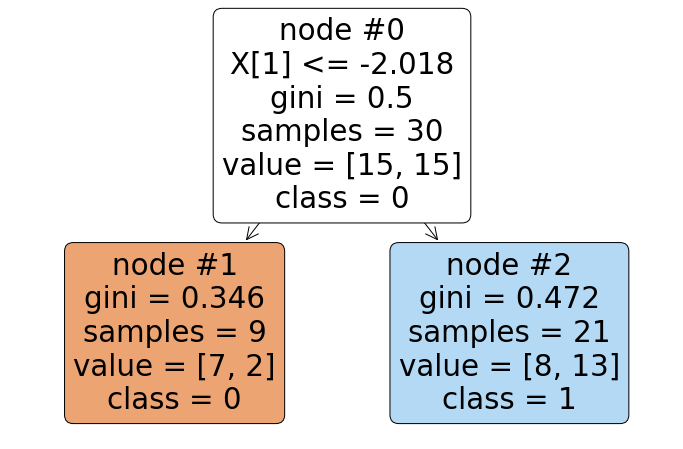

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plot_tree(dtc, class_names=['0', '1'], node_ids=True, rounded=True, filled=True);

diver上では中間の値と書いてあったがなんの中間値？？？

In [10]:
X_75

array([[-0.12243 ,  9.0162  ],
       [ 0.14654 , -0.28733 ],
       [-1.281   , 15.6824  ],
       [ 0.56421 ,  0.72888 ],
       [-1.9948  , -1.3927  ],
       [-4.1013  , -4.353   ],
       [ 1.3763  ,  1.3347  ],
       [-3.0603  , -3.6461  ],
       [-0.44699 , -2.8073  ],
       [-0.73535 , -2.2718  ],
       [-2.234   , -2.5323  ],
       [ 0.10645 ,  1.9242  ],
       [ 0.5461  ,  5.8245  ],
       [-1.4621  , -2.4586  ],
       [-2.9452  , -1.8219  ],
       [-0.57242 , -2.9915  ],
       [-0.9888  ,  4.5718  ],
       [-0.80647 , -2.2135  ],
       [ 0.6017  ,  4.3439  ],
       [ 0.96765 , 10.083   ],
       [-2.9362  ,  2.5462  ],
       [-2.353   , -0.72261 ],
       [ 0.057313,  5.4681  ],
       [-2.1086  ,  8.3428  ],
       [ 0.50214 , -0.31818 ],
       [-0.60216 ,  8.4636  ],
       [ 1.1319  ,  2.4023  ],
       [-3.5944  , -4.0112  ],
       [ 0.58619 ,  0.37158 ],
       [ 0.35084 , -0.031994]])

## 自作モデルでの実行

In [11]:
my_model = ScratchDecesionTreeClassifierDepth1(verbose=True)
my_model.fit(X_75, y_75)

'max_IG : 0.03703703703703712'

'index : 0, col : 0, X : -0.12243'

'left_count : [11  7], right_count : [4 8]'

'max_IG : 0.05656108597285073'

'index : 8, col : 0, X : -0.44699'

'left_count : [11  6], right_count : [4 9]'

'max_IG : 0.06613756613756616'

'index : 17, col : 1, X : -2.2135'

'left_count : [7 2], right_count : [ 8 13]'

In [12]:
my_model.predict(X_25)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
dtc.predict(X_25)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

とりあえず結果は同じにできた

# 【問題6】決定領域の可視化
決定領域を可視化してください。

In [14]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import mglearn

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='x1', ylabel='x2', target_names=['0', '1']):
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step)) 
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)] # グラフ領域(2次元)に左上から00.01-といった形で数字をつけた
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    #plt.subplots(figsize = (10,8))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color)) # 等高線の間の色付
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)# 等高線の描画
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)] # よくわからんけど凡例の書き方を入れてる
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
    plt.legend(handles=patches)
    plt.legend()

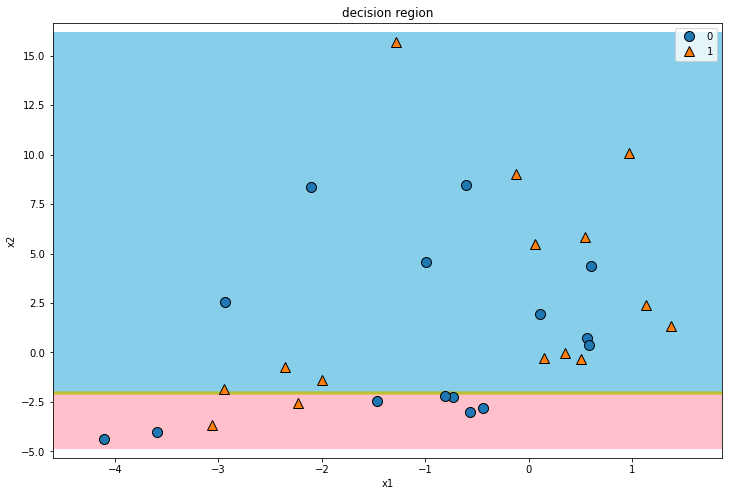

In [15]:
plt.figure(figsize=(12, 8))
decision_region(X_75, y_75, dtc)

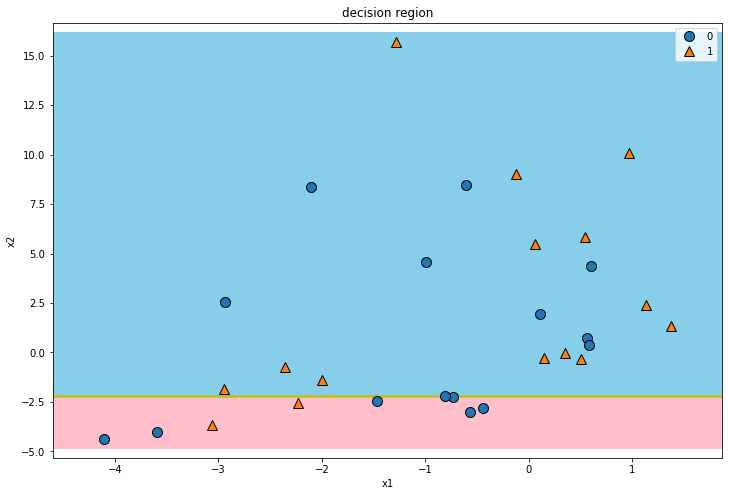

In [16]:
plt.figure(figsize=(12, 8))
decision_region(X_75, y_75, my_model)